### System
$
H = H_0 + H_{SB} = H_S + H_{B} + H_{SB}
$

$
H_S = H_{cav} + H_{atom} + H_{atom,cav}(t)
$

$
H_{cav} = \hbar \omega_c a^{\dagger} a
$

$
H_{atom} =  \hbar \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)} + \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{ij} \sigma_+^{(i)} \sigma_-^{(j)} \quad \text{,} \quad J_{ij} = \frac{\alpha}{|r_i - r_j|^3}
$

$
H_{B} = \sum_k \hbar \omega_k b_k^{\dagger} b_k
$

$
H_{atom,cav}(t) = \hbar  g ( \Sigma_+ + \Sigma_-) \cdot (f(t) a^{\dagger} + f(t)^{*} a)
\quad \text{,} \quad E(t) \equiv f(t) \cdot E_0 \propto \exp^{i \omega t + \phi} \cdot \delta(t) \quad \text{,} \quad g =  \mu * E_0
$

### Decay operators
$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$

$
C_{\text{cav}}^{-} = \sqrt{\gamma_{\kappa} \cdot (1 + n_{th})} (a \otimes 1_{atoms}) \quad C_{\text{cav}}^{+} = \sqrt{\gamma_{\kappa} \cdot n_{th}} (a^{\dagger} \otimes 1_{atoms})
$

In [1]:
import matplotlib.pyplot as plt
from qutip import *
import numpy as np
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = os.getcwd()  # Gets the current working directory
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots #%matplotlib notebook

In [36]:
# =============================
# SYSTEM PARAMETERS
# =============================
# Energy Landscape (Natural Units: c = 1, hbar = 1)
fixed_lam = 1.0                 # Fixed wavelength (arbitrary units)
alpha = 1.0                     # Coupling strength of dipoles (Fine structure constant?)

# Atomic Parameters
omega_a = 2 * np.pi / fixed_lam # Energy splitting of the atom (ground state = 0)
omega_c = 1 * omega_a           # energysplitting of the field  Rabi freq coupling to laser mu = 1 * omega_a                    # Dipole matrix element of each atom
mu      = .2 * omega_a          # Dipole matrix element of each atom
E0      = 5
E0s     = [E0, E0, .1*E0]       # omega_Rabi = mu * E0 (energysplitting of the field  Rabi freq coupling to laser field  -> E_field_0 dot dot Dip_op, parallel

# Lindblad Operators (Decay and Dephasing Rates)
gamma_0     = .1               # Decay rate of the atoms
gamma_kappa = .0               # Decay rate of the cavity
gamma_phi   = .1               # Dephasing rate of the atoms

# =============================
# TOPOLOGY CONFIGURATION
# =============================
n_th_a   = 0.                   # avg number of thermal bath excitation

n_chains = 1                    # Number of chains
n_rings  = 1                    # Number of rings
N_atoms  = n_chains * n_rings   # Total number of atoms
distance = 1.0                  # Distance between atoms (scaled by fixed_lam)

# =============================
# TIME EVOLUTION PARAMETERS
# =============================
t_max           = 100                   # Maximum simulation time
fine_steps      = 1000                   # Number of steps for high-resolution
fine_spacing    = t_max / fine_steps    # high resolution
sparse_spacing  = 10 * fine_spacing     # for T
# Time Arrays

Delta_ts = [1*fine_spacing] * 3 # Pulse widths
omegas = [omega_a] * 3                          # Laser frequencies (on resonance)

times   = np.arange(0, t_max, fine_spacing)       # High-resolution times array to do the evolutions

first_entry = (Delta_ts[1] + Delta_ts[2])
last_entry = np.floor((t_max - (2 * Delta_ts[0] + Delta_ts[1] + Delta_ts[2])) / sparse_spacing) * sparse_spacing
times_T = np.arange(first_entry, last_entry, sparse_spacing)


# Phase Cycling for Averaging
phases = [-i * np.pi / 2 for i in range(4)]

# =============================
# QUANTUM SYSTEM INITIALIZATION     # Define the ground & the excited states
# =============================
# Define Atomic States
# atomic dofs
atom_g  =  basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# cavity dofs   New cavity Hilbert space dimension
cavity_modes = 3

# Create cavity states for 0 to 5 photons
cav_g   =  basis(cavity_modes, 0)                                        # vacuum state (0 photons)
cav_es  = [basis(cavity_modes, i) for i in range(1, cavity_modes)]

# Modify operators accordingly (annihilation and creation)
destroy_cav = destroy(cavity_modes)

# combined dofs
sm_list = [atom_g * atom_es[i].dag() for i in range(N_atoms)] # lowering operators of atomic system
dip_op_list = [mu * (op + op.dag()) for op in sm_list]             # dipole operators for every state  (|i><0|+|0><i|) * mu
Sigma_m = sum(sm_list)
Deph_op = sum([commutator(op_a.dag(), op_b) for op_a in sm_list for op_b in sm_list])
Dip_op = sum(dip_op_list)                # Collective dipole operator


# =============================
# GEOMETRY DEFINITIONS
# =============================
def chain_positions(distance, N_atoms):
    """ Generate atomic positions in a linear chain. """
    return np.array([[0, 0, i * distance] for i in range(N_atoms)])

def z_rotation(angle):
    """ Generate a 3D rotation matrix around the z-axis. """
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

def ring_positions(distance, n_chains):
    """ Generate atomic positions in a ring. """
    dphi = 2 * np.pi / n_chains
    radius = 0 if n_chains == 1 else distance / (2 * np.sin(np.pi / n_chains))
    return np.array([z_rotation(dphi * i) @ [radius, 0, 0] for i in range(n_chains)])

def cyl_positions(distance, N_atoms, n_chains):
    """ Generate atomic positions in a cylindrical structure. """
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    return np.vstack([Pos_chain + Pos_ring[i] for i in range(n_chains)])

# =============================
# MORE FUNCTIONS
# =============================
def sample_frequencies(E0, Delta, N_atoms):
    """ Sample atomic frequencies from a Gaussian distribution. """
    return np.random.normal(loc=E0, scale=Delta / 2, size=N_atoms)

def plot_positive_color_map(x, y, data, T = np.inf, space="real", type="real", positive=False, safe=False):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        x (np.array): 1D array of x values.
        y (np.array): 1D array of y values.
        data (np.array): 2D array of data values aligned with x and y.
        T (float): Temperature parameter to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use only positive values of x and y.
        safe (bool): If True, saves the plot to a file.

    Returns:
        None
    """
    # Convert x and y into 1D arrays if they're not
    x = np.array(x)
    y = np.array(y)

    if positive:
        # Filter for positive x and y values
        positive_x_indices = np.where(x > 0)[0]  # Indices where x > 0
        positive_y_indices = np.where(y > 0)[0]  # Indices where y > 0
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    label = r"$\propto E_{out} / E_0$"# \quad \propto \quad P / E_0
    if space == "real":
        colormap = "viridis"
        title = f"Real space 2D Spectrum (arb. units)"
        if T != np.inf:
            title += f" at T ={T:.2f}"
        x_title = r"$t_{det}$ (arb. units)"
        y_title = r"$\tau_{coh}$ (arb. units)"
    elif space == "freq":
        colormap = "plasma"
        if type == "real":
            title = f"Freq space, Real 2D Spectrum (arb. units)"
            data = np.real(data)
        elif type == "imag":
            title = f"Freq space, Imag 2D Spectrum (arb. units)"
            data = np.imag(data)
        elif type == "abs":
            title = f"Freq space, Abs 2D Spectrum (arb. units)"
            data = np.abs(data)
        elif type == "phase":
            title = "Freq space, Phase 2D Spectrum (arb. units)"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")

        if T != np.inf:
            title += f" at T ={T:.2f}"

        title += f" at T ={T:.2f}"
        x_title = r"$\omega_{t_{det}}$ (arb. units)"
        y_title = r"$\omega_{\tau_{coh}}$ (arb. units)"

    else:
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")

    # Check and adjust the dimensions of x, y, and data
    if data.shape[1] != len(x):
        raise ValueError(f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]}).")
    if data.shape[0] != len(y):
        raise ValueError(f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]}).")

    # Add 1 to the dimensions of x and y for correct pcolormesh behavior
    x = np.concatenate([x, [x[-1] + (x[-1] - x[-2])]])  # Add an extra value for the last x edge
    y = np.concatenate([y, [y[-1] + (y[-1] - y[-2])]])  # Add an extra value for the last y edge

    # Plot the color map
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, data / E0, shading="auto", cmap=colormap)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True
    if safe and output_dir is not None:
        file_name_combined = (
            f"Classical_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_"
            f"{n_rings}x{n_chains}_dist={distance:.2f}_positive={positive}_space={space}"
        )
        if space == "freq":
            file_name_combined += f"_type={type}"
        file_name_combined += ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)

    plt.show()

def Plot_example_evo(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k):
    ylabels = [r"$|g\rangle_{\text{cav}}$", r"$|es\rangle_{\text{cav}}$", r"$|g\rangle_{\text{at}}$", r"$|es\rangle_{\text{at}}$"]

    args0 = {
        'phi': phi_1,
        'time': times_0[0] + Delta_ts[0],
        'omega': omegas[0],
        'Delta': Delta_ts[0],
        'E0': E0
    }
    args1 = {
        'phi': phi_2,
        'time': times_0[i] + Delta_ts[1],
        'omega': omegas[1],
        'Delta': Delta_ts[1],
        'E0': E0s[1]
    }
    args2 = {
        'phi': 0,
        'time': times_1[j-i] + Delta_ts[2],
        'omega': omegas[2],
        'Delta': Delta_ts[2],
        'E0': E0s[2]
    }

    times1 = times_0[:i]
    times2 = times_1[:j]
    times3 = times_2

    # Calculate the electric fields for each time range
    E_1 = [(El_field(t, args0) / E0) for t in times1]
    E_2 = [(El_field(t, args1) / E0) for t in times2]
    E_3 = [(El_field(t, args2) / E0) for t in times3]
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    fig, axs = plt.subplots(len(ylabels)+1, 1, figsize=(15, 10), sharex=True)

    axs[0].plot(times_plot, E_total, label='Electric Field (Real part)', color='black')
    axs[0].set_ylabel('E')

    # Add vertical lines to mark pulse times
    axs[0].axvline(times_0[0] + Delta_ts[0], color='r', linestyle='--', label='Pulse 1')
    axs[0].axvline(times_0[i] + Delta_ts[1], color='g', linestyle='--', label='Pulse 2')
    axs[0].axvline(times_1[j-i] + Delta_ts[2], color='g', linestyle='--', label='Pulse 3')
    axs[0].axvline(times_2[k], color='b', linestyle='--', label='Detection')
    axs[0].legend()

    # Initialize an empty list to store all the data for plotting
    datas = []

    # Append the data for each quantum state based on the times
    datas.append(np.concatenate([data_1.expect[0][:i], data_2.expect[0][:j], data_f.expect[0]]))  # data for first state
    datas.append(np.concatenate([data_1.expect[1][:i], data_2.expect[1][:j], data_f.expect[1]]))  # data for second state
    datas.append(np.concatenate([data_1.expect[2][:i], data_2.expect[2][:j], data_f.expect[2]]))  # data for third state
    datas.append(np.concatenate([data_1.expect[3][:i], data_2.expect[3][:j], data_f.expect[3]]))  # data for fourth state

    # Loop over the datas and plot each expectation value
    for idx, (data, label) in enumerate(zip(datas, ylabels)):
        axs[idx+1].plot(times_plot, data)
        axs[idx+1].set_ylabel(label)
        axs[idx+1].legend()

    fig.suptitle(f"tau = {tau:.2f}, T = {T_val:.2f}")
    axs[-1].set_xlabel('Time (t)')
    plt.tight_layout()
    plt.show()

def jcm_hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H_a = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H_a += alpha / (np.linalg.norm(rb-ra)) * op
            else:
                H_a += omega_a * op                 # Diagonals except for |0><0|
    H_c = omega_c * destroy_cav.dag() * destroy_cav

    return tensor(H_c, qeye(N_atoms+1)) + tensor(qeye(cavity_modes), H_a)

def get_times_for_T(T, spacing=fine_spacing):
    # Adjust the first and last entries of times_tau
    first_tau = (Delta_ts[0] + Delta_ts[1])
    last_tau = np.floor((t_max - Delta_ts[2] - T - Delta_ts[0]) / spacing) * spacing
    times_tau = np.arange(first_tau, last_tau, spacing)
    # Adjust the first and last entries of times_t
    first_t = (Delta_ts[2])
    last_t = np.floor((t_max - Delta_ts[0] - T - 2 * Delta_ts[2]) / spacing) * spacing
    times_t = np.arange(first_t, last_t, spacing)

    return times_tau, times_t
#for i in range(len(times_T)):  # Use range to iterate over indices
#    # Get the result once and store it in a variable
#    result = get_times_for_T(times_T[i])
#
#    # Unpack the result for easier access
#    first_set = result[0]
#    second_set = result[1]
#
#    # Print the desired elements from the result in a formatted manner
#    print(f"Time index {i}:")
#    print(f"  First set: {first_set[0]} {first_set[1]} {first_set[-1]}, {len(first_set)* sparse_spacing}")
#    print(f"  Second set: {second_set[0]} {second_set[1]} {second_set[-1]}, {len(first_set)* sparse_spacing}")
#    print("-" * 40)  # Separator for better readability between each iteratio
#
# =============================
# TIME-DEPENDENT FIELD
# =============================

def envelope(t, t0, Delta):
    E = np.cos(np.pi * (t - t0) / (2 * Delta))**2 * np.heaviside(t - (t0 - Delta), 0) * np.heaviside(t0 + Delta - t, 0)
    return E
def El_field(t, args):
    """ Define a time-dependent electric field pulse. """
    t0, Delta, omega, phi, E0 = args['time'], args['Delta'], args['omega'], args['phi'], args['E0']
    E  = np.exp(1j * (omega * t + phi))
    E *= envelope(t, t0, Delta)
    return  E0 * E
def El_field_op(t, args):
    E    = El_field(t, args)
    a    = tensor(destroy_cav, qeye(N_atoms+1))
    E_op = a.dag() * E + a * np.conj(E)
    return E_op

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0.         1.         0.        ]
 [1.         0.         1.41421356]
 [0.         1.41421356 0.        ]] Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         1.25663706]
 [1.25663706 0.        ]]


In [37]:
# =============================
# COLLAPSE AND EXPECT OPERATORS
# =============================
def jcm_c_ops(cavity_modes, n_th_a):
    c_op_list = []
    # Collapse operators for the cavity (decay to photon numbers 0 to 5)
    rate = gamma_kappa * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * tensor(destroy_cav, qeye(N_atoms+1)))
    # excitation operators of the cavity, if temperature > 0
    rate = gamma_kappa * n_th_a
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * tensor(destroy_cav.dag(), qeye(N_atoms+1)))
    # Decay operators for the atoms
    rate = gamma_0
    if rate > 0.0:
       c_op_list.append(np.sqrt(rate) * tensor(qeye(cavity_modes), Sigma_m))
    # Dephasing operators for the atoms
    rate = gamma_phi
    if rate > 0.0:
        c_op_list.append([np.sqrt(rate) * tensor(qeye(cavity_modes), Deph_op)])
    return c_op_list

e_op_list = [tensor(cav_g * cav_g.dag(), qeye(N_atoms+1)),                                                  # cavity ground
             sum([tensor(cav_es[i] * cav_es[i].dag(), qeye(N_atoms+1)) for i in range(cavity_modes - 1)]),  # cavity excited states
             tensor(qeye(cavity_modes), (atom_g * atom_g.dag())),                                           # atomic ground state
             sum([tensor(qeye(cavity_modes), (atom_es[i] * atom_es[i].dag())) for i in range(N_atoms)])]    # atomic excited states

wc = 3
def ohmic_spectrum_at_decay(w):
    return gamma_0 / 2 * (w / (2 * np.pi)) * (w > 0.0)
    return gamma_0 * w/wc * np.exp(-w/wc) * (w > 0.0)
def ohmic_spectrum_at_deph(w):
    return gamma_phi / 2 * (w / (2 * np.pi)) * (w > 0.0)
    return gamma_phi * w/wc * np.exp(-w/wc) * (w > 0.0)
def ohmic_spectrum_cav(w):
    return gamma_kappa / 2 * (w / (2 * np.pi)) * (w > 0.0)
    return gamma_kappa * w/wc * np.exp(-w/wc) * (w > 0.0)
def S_w(w):
    return (n_th_a + 1) * gamma_kappa * (w > 0.0)

a_op_list = [[tensor(qeye(cavity_modes), Dip_op) ,  ohmic_spectrum_at_decay],
             [tensor(qeye(cavity_modes), Deph_op) ,  ohmic_spectrum_at_deph],
             [tensor(destroy_cav.dag() + destroy_cav, qeye(N_atoms+1)).dag(), ohmic_spectrum_cav]]

# =============================
# SYSTEM EVOLUTION
# =============================
def H_int(t, args):
    return - tensor(qeye(cavity_modes), Dip_op) * El_field_op(t, args)

test_args = {
        'phi': 0,
        'time': times[0] + Delta_ts[0],
        'omega': omegas[0],
        'Delta': Delta_ts[0],
        'E0': E0
    }
# Define System Hamiltonian
H0 = jcm_hamilton0(distance, n_rings, n_chains)
H_sys = H0 + QobjEvo(H_int, args=test_args)

# initial state
psi_ini = tensor(sum(cav_es).unit(), atom_g)
#psi_ini = tensor(cav_g, sum(atom_es).unit())

100%|██████████| 999/999 [00:12<00:00, 80.57it/s] 


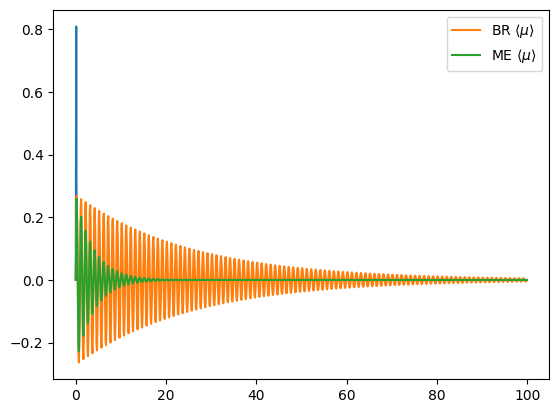

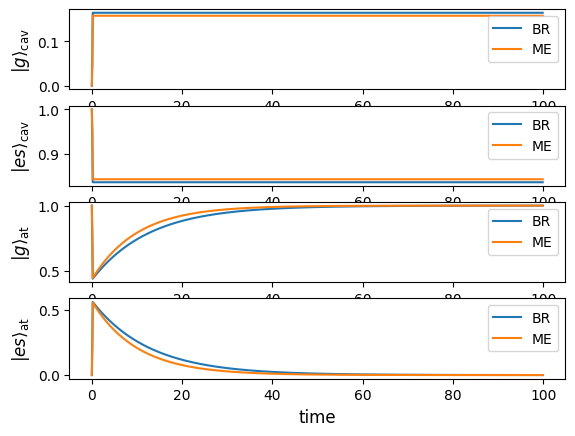

In [38]:
# #################
# TEST
# #################

args = {'phi': 0, 'time': times[0] + 1*Delta_ts[0], 'omega': omegas[0], 'Delta': 1*Delta_ts[0], 'E0': E0}
progress_bar='tqdm'                     # Enable tqdm progress bar (or 'text', 'enhanced')
options = Options(store_states=True,    # Save the states from the Qutip calculation
progress_bar=progress_bar,)             # Enable tqdm progress bar (or 'text', 'enhanced')

result_me = mesolve(  H_sys, psi_ini, times, c_ops=jcm_c_ops(cavity_modes, n_th_a), e_ops=e_op_list, args=args, options=options)
result_br = brmesolve(H_sys, psi_ini, times, a_ops=a_op_list,                       e_ops=e_op_list, args=args, options=options)

plt.plot(times, [El_field(t, args)/ E0 for t in times])
plt.plot(times, expect(tensor(qeye(cavity_modes), Dip_op),  result_br.states), label=r"BR $\langle \mu \rangle$")
plt.plot(times, expect(tensor(qeye(cavity_modes), Dip_op),  result_me.states), label=r"ME $\langle \mu \rangle$")
plt.legend()

fig, axes = plot_expectation_values([result_br, result_me], ylabels=[r"$|g\rangle_{\text{cav}}$", r"$|es\rangle_{\text{cav}}$", r"$|g\rangle_{\text{at}}$", r"$|es\rangle_{\text{at}}$"])
for ax in axes:
    ax.legend(labels=["BR", "ME"], loc="best")  # Adjust labels and location as needed
plt.show()

/tmp/ipykernel_651040/2708166446.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[idx+1].legend()


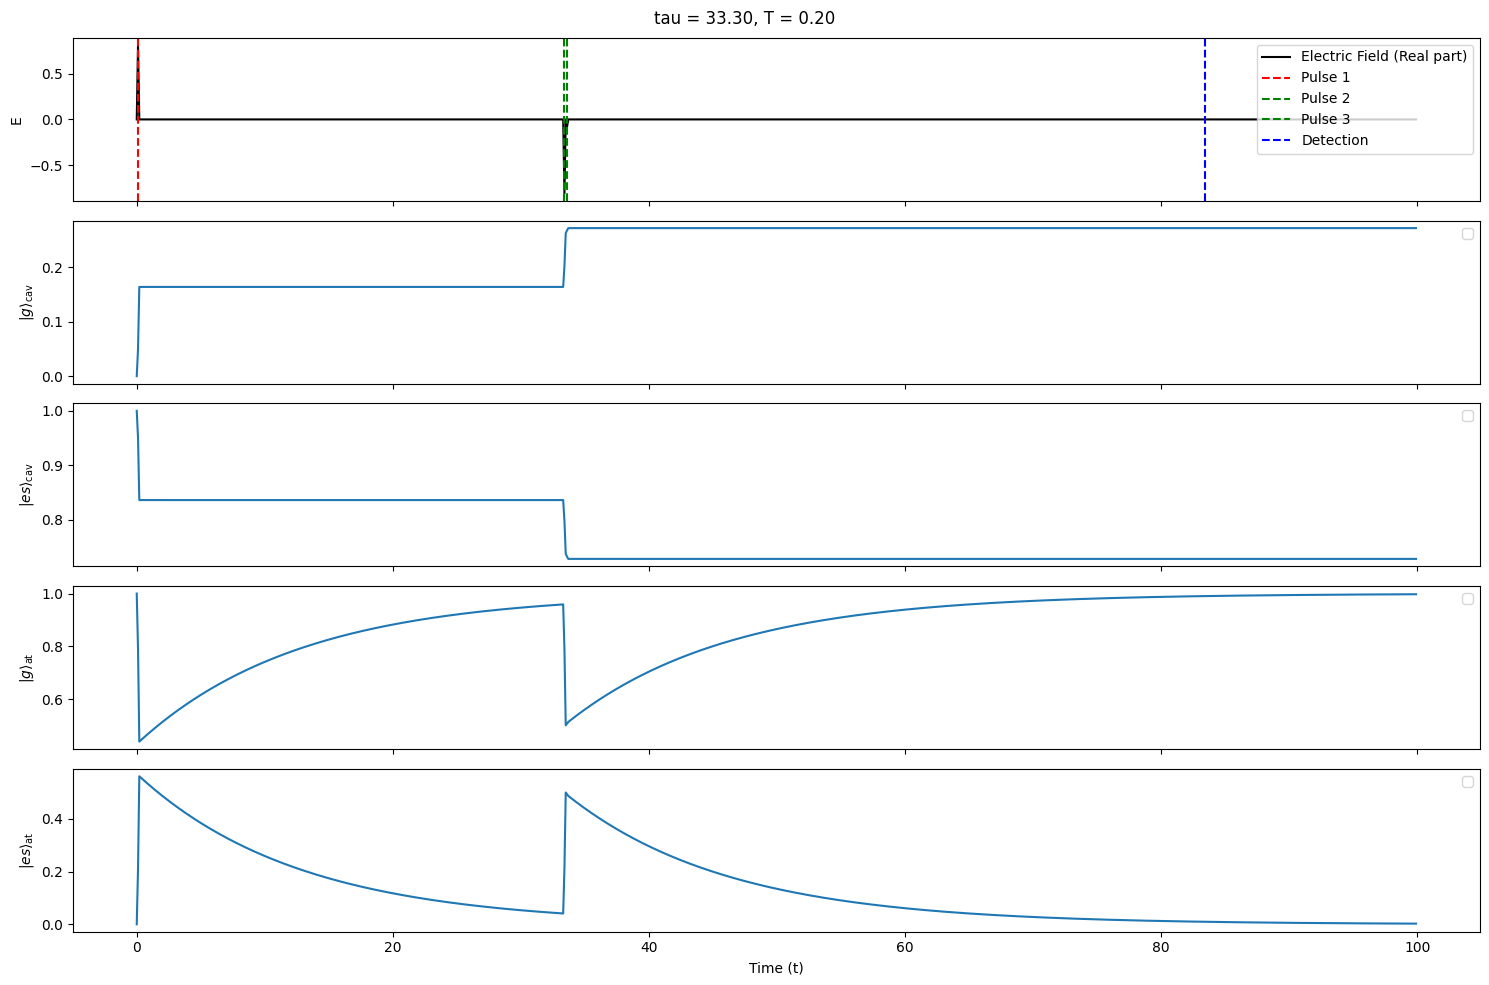

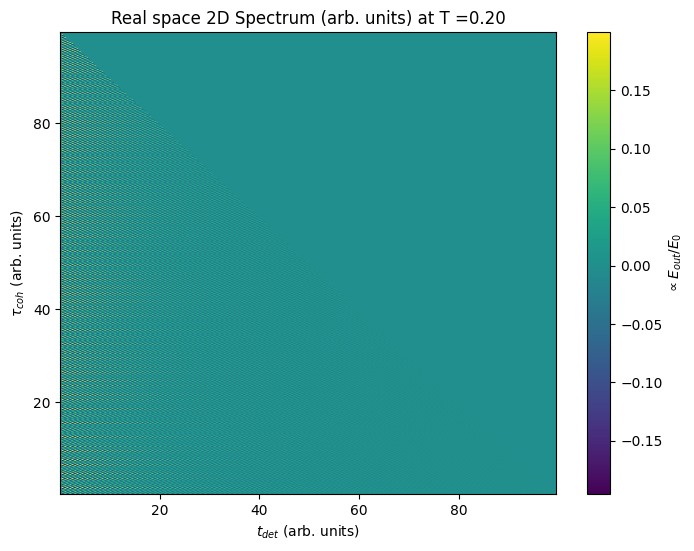

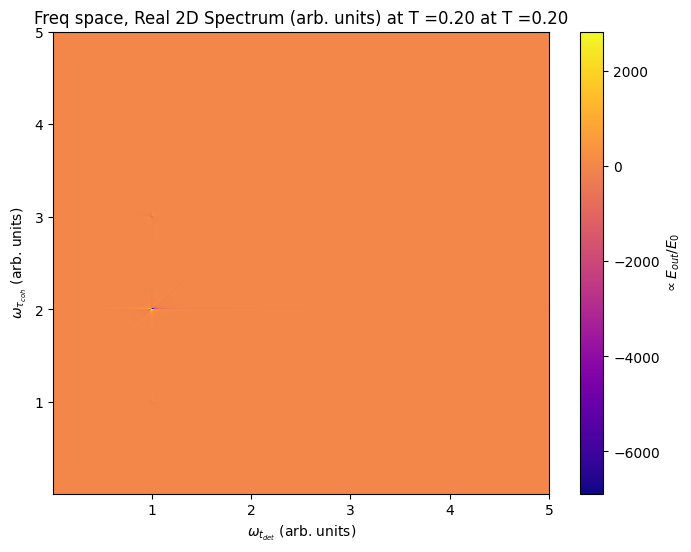

In [39]:
## Calculations

### Compute Pulse
def compute_pulse(psi_ini, times, phi, i):
    progress_bar = ""
    if i == 2 and times[0] >= times[len(times)//2]:
        progress_bar='tqdm'

    options = Options(store_states=True, progress_bar=progress_bar,)   # Enable tqdm progress bar (or 'text', 'enhanced')
    args = {
        'phi': phi,
        'time': times[0] + Delta_ts[i],
        'omega': omegas[i],
        'Delta': Delta_ts[i],
        'E0': E0s[i]
    }
    #result = mesolve(  H_sys, psi_ini, times, c_ops=jcm_c_ops(cavity_modes, n_th_a), e_ops=e_op_list, args=args, options=options)
    result = brmesolve(H_sys, psi_ini, times, a_ops=a_op_list,                       e_ops=e_op_list, args=args, options=options)
    return result

### Compute Two-Dimensional Polarization
def compute_two_dimensional_polarization(T_val, phi_1, phi_2):
    # get the symmetric times, t / tau
    tau_values, t_values = get_times_for_T(T_val)

    # initialize the time domain Spectroscopy
    data = np.zeros((len(tau_values), len(t_values)))

    # only make the necessary steps (don't calculate too many states that we don't need)
    index_0 = np.abs(times - (tau_values[-1] - Delta_ts[1] + Delta_ts[0])).argmin()  # Find the closest index to reduce computation time
    times_0 = times[:index_0+1]

    # calculate the evolution of the first pulse in the desired range
    data_1  = compute_pulse(psi_ini, times_0, phi_1, 0)

    # for every tau value -> calculate the next pulses
    for tau_idx, tau in enumerate(tau_values):
        # find the position in times, which corresponds to the current tau
        i       = np.abs((times_0 + Delta_ts[1] - Delta_ts[0]) - tau_values[tau_idx]).argmin()

        # take this state and evolve it with the second pulse, but only as far as desired
        psi_1   = data_1.states[i]

        # select range
        j = np.abs((times - times_0[i] - Delta_ts[1] + Delta_ts[2]) - T_val).argmin()  # Find the closest index to reduce computation time
        times_1 = times[i:j+1]

        data_2  = compute_pulse(psi_1, times_1, phi_2, 1)
        psi_2   = data_2.states[j-i]

        times_2 = times[j:]

        data_f  = compute_pulse(psi_2, times_2, 0, 2)

        for t_idx, t in enumerate(t_values):
            if t_idx + tau_idx < len(tau_values):

                k = np.abs(t_values[t_idx] - (times_2 - times_2[0] - Delta_ts[2])).argmin()
                psi_f = data_f.states[k]
                data[tau_idx, t_idx] = expect(tensor(qeye(cavity_modes), Dip_op), psi_f)

                # make one plot for this case
                if t == t_values[len(t_values)//2] and tau == tau_values[len(tau_values)//3]:
                    Plot_example_evo(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k)

    return tau_values, t_values, data

### Test Computation
T_test = times_T[0]
data_test_0 = compute_two_dimensional_polarization(T_test, phases[0], phases[0])
plot_positive_color_map(data_test_0[1], data_test_0[0], data_test_0[2], T=T_test, safe=False)
tfreqs = np.fft.fftfreq(len(data_test_0[1]), d=(data_test_0[1][1] - data_test_0[1][0]))
taufreqs = np.fft.fftfreq(len(data_test_0[0]), d=(data_test_0[0][1] - data_test_0[0][0]))
plot_positive_color_map(tfreqs, taufreqs, np.fft.fft2(data_test_0[2]), positive=True, type="real", space="freq", T=T_test, safe=False)

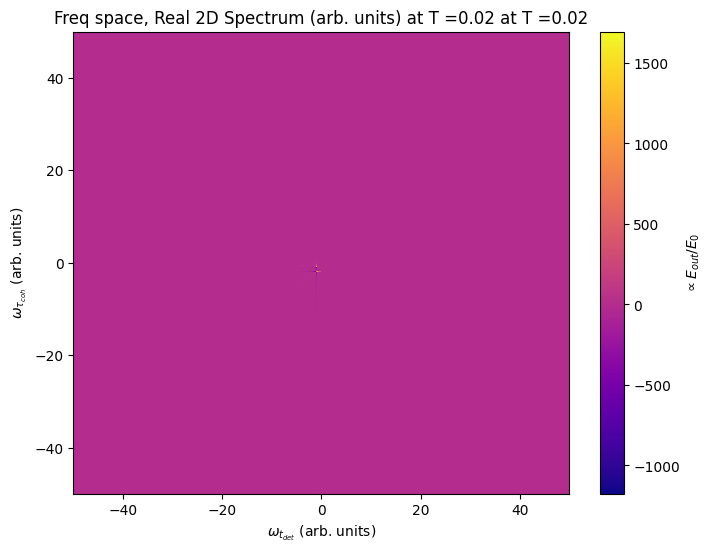

In [35]:
plot_positive_color_map(tfreqs, taufreqs, np.fft.fft2(data_test_0[2]), positive=False, type="real", space="freq", T=T_test, safe=False)